In [147]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pickle
import sklearn as sk
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from munkres import Munkres
import pandas as pd
from ktools import *
import igraph as ig
import leidenalg
import tqdm
from collections import defaultdict

In [148]:
res = {}


In [149]:
label_colors = {"louvain":sns.color_palette()[0],
                "leiden": sns.color_palette()[1],
                "gn":sns.color_palette()[2]}

# Importing Data

Data Set

In [150]:
def create_adjacency(df:pd.DataFrame)->np.array:
    m = max(max(df["zero"].value_counts().index), max(df["one"].value_counts().index)) + 1
    A = np.zeros((m,m))
    a,b = df["zero"].to_numpy(dtype=int), df["one"].to_numpy(dtype=int)

    A[a,b] =1
            
    return A

In [151]:
data = pd.read_csv(r"data\email-Eu-core-temporal.txt.gz")
data = data.map(str.split)
series_d, series_0,  series_1, t = data.map(lambda x:(x[0], x[1])).values.flatten(),data.map(lambda x:x[0]).values.flatten(), data.map(lambda x:x[1]).values.flatten(), data.map(lambda x:x[2]).values.flatten()

series_d = pd.Series(series_d)
wt = pd.Series(series_d).value_counts()


to_integer = np.vectorize(int)
edges = pd.DataFrame({"zero": to_integer(series_0), "one": to_integer(series_1), "d": series_d, "w": series_d.map(lambda x: wt[x])})


edges

,zero,one,d,w
0,168,472,"(168, 472)",668
1,168,912,"(168, 912)",1212
2,2,790,"(2, 790)",229
3,2,322,"(2, 322)",10
4,2,790,"(2, 790)",229
...,...,...,...,...
332328,324,367,"(324, 367)",1
332329,790,126,"(790, 126)",150
332330,790,126,"(790, 126)",150
332331,782,126,"(782, 126)",54


In [152]:
edges

,zero,one,d,w
0,168,472,"(168, 472)",668
1,168,912,"(168, 912)",1212
2,2,790,"(2, 790)",229
3,2,322,"(2, 322)",10
4,2,790,"(2, 790)",229
...,...,...,...,...
332328,324,367,"(324, 367)",1
332329,790,126,"(790, 126)",150
332330,790,126,"(790, 126)",150
332331,782,126,"(782, 126)",54


In [153]:
#handling the edges
data = pd.read_csv(r"data\email-Eu-core.txt.gz")
data = data.map(str.split)
series_0 = data.map(lambda x:x[0]).values.flatten()
series_1 = data.map(lambda x:x[1]).values.flatten()

to_integer = np.vectorize(int)
series_0 = to_integer(series_0)


df = pd.DataFrame({"zero": to_integer(series_0), "one": to_integer(series_1)})
df = df.dropna()
df

,zero,one
0,2,3
1,2,4
2,5,6
3,5,7
4,8,9
...,...,...
25565,420,143
25566,174,859
25567,440,460
25568,52,786


In [154]:
# Handling the Labels
labels = pd.read_csv(r"data\email-Eu-core-department-labels.txt.gz")

labels= labels.map(str.split)
series_0 = labels.map(lambda x:x[0]).values.flatten()
series_1 = labels.map(lambda x:x[1]).values.flatten()

to_integer = np.vectorize(int)
series_0 = to_integer(series_0)
labels = pd.DataFrame({"node": to_integer(series_0), "label": to_integer(series_1)})
labels = labels.dropna()

In [155]:
comms = {label: list(labels[labels["label"] == label]["node"]) for label in labels["label"].unique()}
labels["community"] = labels["label"].map(comms)

In [156]:
A = create_adjacency(df)
eucore = nx.from_numpy_array(A)
nx.set_node_attributes(eucore, labels["community"], "community")
eucore.remove_node(1004)

Random Networks


In [157]:
def import_random_state():
    random_state_integers = np.loadtxt("random_state_integers.txt")
    enc="MT19937"
    params = []
    with open(r'random_state_params.txt', 'r') as fp:
        for line in fp:
            # remove linebreak from a current name
            # linebreak is the last character of each line
            x = line[:-1]

            # add current item to the list
            params.append(x)

    params[0] = int(params[0])
    params[1] = int(params[1])
    params[2] = float(params[2])

    params.insert(0,enc)
    params.insert(1, random_state_integers)
    
    return tuple(params)

In [158]:
np.random.set_state(import_random_state())

In [159]:
G_small = pickle.load(open('small50.pickle', 'rb'))

In [160]:
G_medium = pickle.load(open('medium250.pickle', 'rb'))

In [161]:
G_large = pickle.load(open('large250.pickle', 'rb'))

In [162]:
def create_gcl(G):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}

    # ----------------------------- generating_labels ---------------------------- #
    ground_community_labels = {}
    counter =0

    for i in ground:
        if i not in ground_community_labels:
            ground_community_labels[i] = counter
            counter += 1

    gcl = [ground_community_labels[frozenset(G.nodes[node]["community"])]  for node in G.nodes]

    return gcl

In [163]:
def create_lcl(comms,G):
    """create labels for the outcome communities commmunties
    """
    counter = 0    
    community_dict = {}
    for i in comms:
        if i not in community_dict:
            community_dict[i] = counter
        counter += 1

    lcl = []
    for node in G.nodes:
        c = [x for x in comms if node in x]
        c = c[0]
        lcl.append(community_dict[c])

    return lcl

# Creating Baselines

### Baseline Louvain

In [164]:
def baseline_metrics_louvain(G, n=15):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}

    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #
    gcl = create_gcl(G)

    generated_communities = [nx.community.louvain_communities(G, weight=None) for _ in range(n)]
    
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []
    l_accur = []


    for _ in range(n):
        counter =0
        comms = nx.community.louvain_communities(G)
        comms = [frozenset(i) for i in comms]

        lcl = create_lcl(comms,G)

        l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

        #calculating kappa   
        l_kappa.append(total_kappa(gcl, lcl))
        l_accur.append(total_accuracy(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 
    stats_dict["accuracy"] = np.mean(l_accur)

    return stats_dict

In [165]:
res["louvain_small"] =baseline_metrics_louvain(G_small)
res["louvain_small"]

{'a_modularity': 0.2187162543016494,
 'var_modularity': 8.347033503596682e-05,
 'a_nmi': 0.41323414766553,
 'var_nmi': 0.0009964689109266845,
 'a_kappa': 0.1565245308350115,
 'var_kappa': 0.018582512979272003,
 'accuracy': 0.2034751227883223}

In [166]:
res["louvain_medium"] = baseline_metrics_louvain(G_medium)

In [167]:
res["louvain_large"] = baseline_metrics_louvain(G_large)

In [168]:
res["louvain_eucore"] = baseline_metrics_louvain(eucore)

### Baseline Leiden

In [169]:
def run_leiden(G):
    """"Runs the Leidein Algorithm in a graph G"""
    h = ig.Graph.from_networkx(G)
    partition = leidenalg.find_partition(h, leidenalg.ModularityVertexPartition)
    communities = [[] for _ in range(len(partition))]
    # Fill the communities with vertex indices
    for vertex, community in enumerate(partition.membership):
        communities[community].append(vertex)

    return communities    

In [170]:
def baseline_metrics_leiden(G, n=15):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}

    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #
    gcl = create_gcl(G)

    generated_communities = [run_leiden(G) for _ in range(10)]
    
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []


    for _ in range(n):
        counter =0
        comms = run_leiden(G)
        comms = [frozenset(i) for i in comms]

        lcl = create_lcl(comms,G)

        l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

        #calculating kappa   
        l_kappa.append(total_kappa(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 


    return stats_dict



In [171]:
res["leiden_small"] = baseline_metrics_leiden(G_small)

In [172]:
res["leiden_medium"] = baseline_metrics_leiden(G_medium)

In [173]:
res["leiden_large"] = baseline_metrics_leiden(G_large)

In [174]:
res["leiden_eucore"] = baseline_metrics_leiden(eucore)

### Baseline GN

In [175]:
# nx.community.girvan_newman(G_medium)
# comp = nx.community.girvan_newman(G_large)
# gn = tuple(sorted(c) for c in next(comp))

# gn_communities = {}

# for communities in tqdm.tqdm(np.itertools.islice(comp, 3)):
#     print(tuple(sorted(c) for c in communities))

In [176]:
def baseline_metrics_gn(G, n=15):
    ground = {frozenset(G.nodes[v]["community"]) for v in G}
    
    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #
    ground_community_labels = {}
    counter =0

    for i in ground:
        if i not in ground_community_labels:
            ground_community_labels[i] = counter
            counter += 1

    gcl = [ground_community_labels[frozenset(G.nodes[node]["community"])]  for node in G.nodes]
    
    nx.community.girvan_newman(G)
    comp = nx.community.girvan_newman(G)
    gn = tuple(sorted(c) for c in next(comp))

    generated_communities = [{frozenset(c) for c in gn}] 
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []
    
    comms = frozenset(generated_communities[0]) 
    counter = 0


    community_dict = {}
    for i in comms:
        if i not in community_dict:
            community_dict[i] = counter
        counter += 1

    lcl = []
    for node in G.nodes:
        c = [x for x in comms if node in x]
        c = c[0]
        lcl.append(community_dict[c])

    l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

    #calculating kappa   
    l_kappa.append(total_kappa(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 


    return stats_dict

In [177]:
res["gn_small"] = baseline_metrics_gn(G_small)

In [178]:
res["gn_medium"] = baseline_metrics_gn(G_medium)


In [179]:
res["gn_large"] =  baseline_metrics_gn(G_medium)

In [180]:
# res["gn_eucore"] = baseline_metrics_gn(eucore)

In [181]:
modularities = [res[key]["a_modularity"] for key in res ]
nmis = [res[key]["a_nmi"] for key in res ]
kappas = [res[key]["a_kappa"] for key in res ]



colors = [label_colors[str(key).split("_")[0]] for key in res]
res.keys()


dict_keys(['louvain_small', 'louvain_medium', 'louvain_large', 'louvain_eucore', 'leiden_small', 'leiden_medium', 'leiden_large', 'leiden_eucore', 'gn_small', 'gn_medium', 'gn_large'])

C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_21500\2088141532.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_21500\2088141532.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
C:\Users\Felipe Cintra\AppData\Local\Temp\ipykernel_21500\2088141532.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")


Text(0.5, 0.98, 'Performance Metrics of Baseline Algorithms')

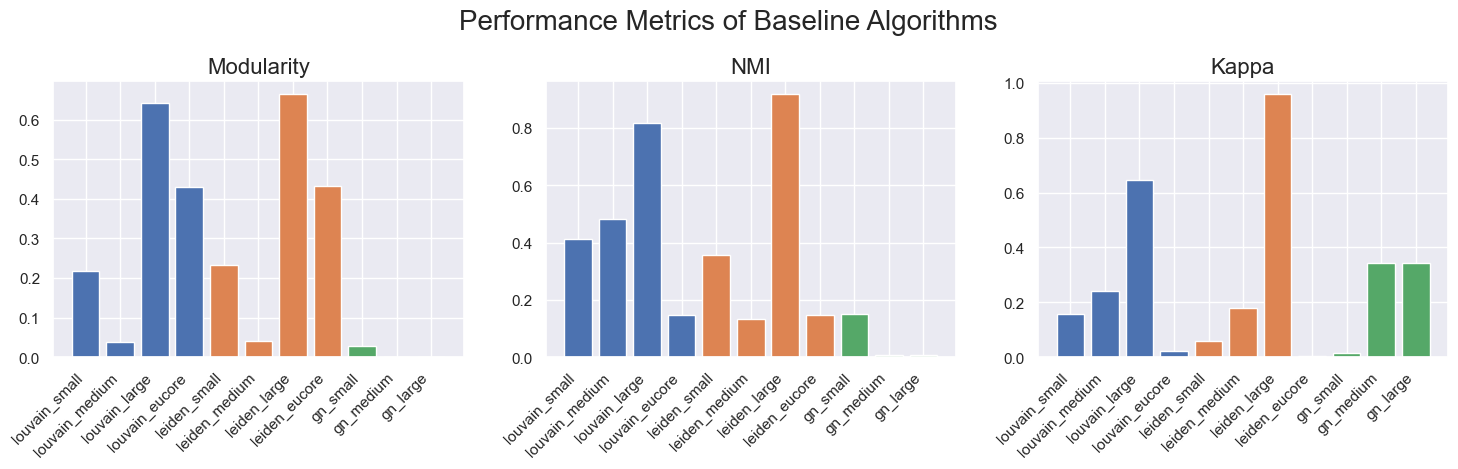

In [182]:
fig, ax = plt.subplots(1,3, figsize=(18,4))

# modularity
ax[0].bar([key for key in res], modularities, color=colors)
ax[0].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[0].set_title("Modularity", fontsize=16)


# nmi
ax[1].bar([key for key in res], nmis, color=colors)
ax[1].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[1].set_title("NMI", fontsize=16)

# kappa
ax[2].bar([key for key in res], kappas, color=colors)
ax[2].set_xticklabels(ax[0].get_xticklabels(),  rotation=45, horizontalalignment="right")
ax[2].set_title("Kappa", fontsize=16)

plt.subplots_adjust(top=0.8)
plt.suptitle("Performance Metrics of Baseline Algorithms", fontsize=20)


In [183]:
res_flow_capacity = {}
alpha_mod = {}

In [184]:
def flow_capacity_louvain_mod(G, quality="m"):
    metric_dict = {}
    alpha_vals = np.arange(0,1, 0.1)
    gcl = create_gcl(G)
    
    for alpha in alpha_vals: #training
        A = nx.adjacency_matrix(G, weight=None)
        I = nx.adjacency_matrix(G, weight="weight")/np.sum(nx.adjacency_matrix(G, weight="weight"))
        F = (1-alpha)*A + alpha*I
        F = nx.from_numpy_array(F)
        # ---------------------------------- running algorithm --------------------------------- #

 
        generated_communities = [nx.community.louvain_communities(F, weight="weight") for _ in tqdm.tqdm(range(5))]


        if quality == "m":   # metric = modularity
            metric_dict[alpha]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])

        else:
            l = []

            for comms in generated_communities:
                comms = [frozenset(i) for i in comms]
                lcl = create_lcl(comms,G)

                if quality == "n":
                    l.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl)) # metric nmi
                else:
                    l.append(total_kappa(gcl, lcl)) # metric kappa

            metric_dict["alpha"] = np.mean(l)



    # ------------------------- applying trained version ------------------------- #

    alpha_index, max_metric = max(enumerate(metric_dict.values())) #gets index with highest alpha value, gets highest metric value
    max_alpha = alpha_vals[alpha_index]

    I = nx.adjacency_matrix(G, weight="weight")/np.sum(nx.adjacency_matrix(G, weight="weight"))
    F = (1-max_alpha)*A + max_alpha*I
    
    F = nx.from_numpy_array(F)

    stats_dict = {}
    # ----------------------------- generating_labels ---------------------------- #


    generated_communities = [nx.community.louvain_communities(F) for _ in range(10)]
    
    #calculating modularity    
    stats_dict["a_modularity"]  = np.mean([nx.community.modularity(G,c) for c in generated_communities])
    stats_dict["var_modularity"]  = np.var([nx.community.modularity(G,c) for c in generated_communities])

    #calculating nmi and kappa
    l_nmi = []
    l_kappa = []
    l_accur = []


    for _ in range(15):
        counter =0
        comms = nx.community.louvain_communities(F)
        comms = [frozenset(i) for i in comms]

        lcl = create_lcl(comms,G)

        l_nmi.append(sk.metrics.cluster.normalized_mutual_info_score(gcl, lcl))

        #calculating kappa   
        l_kappa.append(total_kappa(gcl, lcl))
        l_accur.append(total_accuracy(gcl, lcl))


    stats_dict["a_nmi"]  = np.mean(l_nmi)
    stats_dict["var_nmi"]  = np.var(l_nmi) 

    stats_dict["a_kappa"]  = np.mean(l_kappa)
    stats_dict["var_kappa"]  = np.var(l_kappa) 
    stats_dict["accuracy"] = np.mean(l_accur)

    
    return stats_dict, max_alpha, max_metric    

In [185]:
stats, alpha, max_mod = flow_capacity_louvain_mod(G_small)
res_flow_capacity["louvain_small"] =  stats
alpha_mod["louvain_small"] = [alpha, max_mod]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 315.17it/s]


In [186]:
stats, alpha, max_mod = flow_capacity_louvain_mod(G_medium)
res_flow_capacity["louvain_medium"] =  stats
alpha_mod["louvain_medium"] = [alpha, max_mod]


100%|██████████| 5/5 [00:00<00:00, 11.60it/s]


In [187]:
# stats, alpha, max_mod = flow_capacity_louvain_mod(G_large)
# res_flow_capacity["louvain_large"] =  stats
# alpha_mod["louvain_large"] = [alpha, max_mod]


In [188]:
stats, alpha, max_mod = flow_capacity_louvain_mod(eucore, quality="k")
res_flow_capacity["louvain_eucore"] =  stats
alpha_mod["louvain_eucore"] = [alpha, max_mod]

stats, alpha, max_mod

100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


({'a_modularity': 0.431444439814012,
  'var_modularity': 3.696929996901878e-06,
  'a_nmi': 0.15177716966064667,
  'var_nmi': 3.517762881385585e-05,
  'a_kappa': 0.021247324019245395,
  'var_kappa': 0.00035905817216437167,
  'accuracy': 0.007791830272208597},
 0.0,
 0.01671729529839791)

In [189]:
stats, alpha, max_mod = flow_capacity_louvain_mod(eucore, quality="q")
res_flow_capacity["louvain_eucore"] =  stats
alpha_mod["louvain_eucore"] = [alpha, max_mod]


stats, alpha, max_mod

100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


({'a_modularity': 0.42967930445715385,
  'var_modularity': 5.163602354115038e-06,
  'a_nmi': 0.15224947028608218,
  'var_nmi': 1.667671081936234e-05,
  'a_kappa': 0.018316128964579372,
  'var_kappa': 0.00019329122228817444,
  'accuracy': 0.006261681791276507},
 0.0,
 0.014319044799125708)

In [190]:
stats, alpha, max_mod = flow_capacity_louvain_mod(eucore, quality="n")
res_flow_capacity["louvain_eucore"] =  stats
alpha_mod["louvain_eucore"] = [alpha, max_mod]

stats, alpha, max_mod

100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


({'a_modularity': 0.4310502238993276,
  'var_modularity': 2.4263218460461157e-06,
  'a_nmi': 0.1470872103261935,
  'var_nmi': 6.404929490355504e-05,
  'a_kappa': 0.013053301480065381,
  'var_kappa': 8.210239271550779e-05,
  'accuracy': 0.004628109533753543},
 0.0,
 0.15577750706640398)

In [191]:
alpha_mod

{'louvain_small': [0.9, 0.22131430224279103],
 'louvain_medium': [0.9, 0.03820676195127551],
 'louvain_eucore': [0.0, 0.15577750706640398]}